## ENV

In [ ]:
from google.colab import drive
from tqdm import tqdm, trange
import os
from pathlib import Path
from typing import Union, Literal, Optional
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import pandas as pd
import time
%matplotlib inline

## 2D Hyper plane (i.e. a line) implementation

In [ ]:
class Hyperplane2D():
    eps = 1e-9
    def __init__(self, norm_vector:np.ndarray, x_pos=True) -> None:
        self.norm_vector = norm_vector*(-1) if norm_vector[0] < 0 and x_pos else norm_vector.astype(np.float32)
        self.dir_vec = self.norm_vector[[1, 0, 2]]
        self.dir_vec[-1] = 0
        self.dir_vec[1] = -self.dir_vec[1]
        self.norm_vector = np.expand_dims(self.norm_vector, 0)
        self.dir_vec = np.expand_dims(self.dir_vec, 0)

    @staticmethod
    def unit_vec(v:np.ndarray) -> np.ndarray:
        return v[0, :2]/np.linalg.norm(v[0, :2])


    def cosine_simi(self, other:"Hyperplane2D")->np.ndarray:
        return Hyperplane2D.unit_vec(self.norm_vector)@Hyperplane2D.unit_vec(other.norm_vector).T


    @property
    def unit_dir_vec(self) -> np.ndarray:
        d = Hyperplane2D.unit_vec(self.dir_vec)
        return np.sign(d[0])*d

    @property
    def unit_norm_vec(self) -> np.ndarray:
        d = Hyperplane2D.unit_vec(self.norm_vector)
        return np.sign(d[0])*d

    def _solve(self, known_x:Union[float, np.ndarray], correspond_axis:int)->Union[float, np.ndarray, bool]:

        if np.abs(self.norm_vector[0,1-correspond_axis]) < self.eps:
            # coeffient = 0
            return False

        return (-self.norm_vector[0,2] - self.norm_vector[0, correspond_axis]*known_x)/self.norm_vector[0,1-correspond_axis]

    def get_x0(self, x1:Union[float, np.ndarray])->Union[float, np.ndarray]:
        return self._solve(x1, 1)

    def get_x1(self, x0:Union[float, np.ndarray])->Union[float, np.ndarray]:
        return self._solve(x0, 0)

    def make_line_sample(self, xrange:tuple, corresponding_axis:int=0, n_points:int=200) ->np.ndarray:

        assert isinstance(corresponding_axis, int) and corresponding_axis < 2 and corresponding_axis > -1

        known_x = np.linspace(xrange[0], xrange[1], n_points)

        other_x = self._solve(known_x=known_x, correspond_axis=corresponding_axis)
        if other_x is False:
            known_x, other_x = np.ones_like(known_x)*(-self.norm_vector[0, 2])/self.norm_vector[0, corresponding_axis], known_x

        other_x_axis = 1-corresponding_axis
        all_data = [None, None]
        all_data[corresponding_axis] = known_x
        all_data[other_x_axis] = other_x
        return np.vstack(all_data)

    def make_line_sample_with_len(self, xstart:float, line_len:float, n_point:int=200) -> np.ndarray:

        unit_dir_vec = line_len*self.unit_dir_vec
        xend = xstart + unit_dir_vec[0]
        return self.make_line_sample(xrange=(xstart, xend), n_points=n_point)

    def expand_x(self, x:np.ndarray)->np.ndarray:
        x_aug = None
        if x.ndim == 2:
            if x.shape[0] == 2:
                x_aug = x
            elif x.shape[1] == 2:
                x_aug = x.T
            else:
                raise ValueError("Only accept 2D input")
        elif x.ndim==1:
            x_aug = np.expand_dims(x, 1)
        else:
            raise ValueError("Only accept 2D input")

        return np.vstack([x_aug, np.ones((1,x_aug.shape[1]))])

    def __call__(self, x:np.ndarray) -> np.ndarray:
        x_aug = self.expand_x(x=x)
        return (self.norm_vector@x_aug).squeeze()

    def __repr__(self) -> str:
        return f"[{', '.join(f'{num:.3f}' for num in self.norm_vector[0])}]•[x 1] = 0"

    def orthogonal_hyp(self):
        return Hyperplane2D(norm_vector=self.dir_vec[0])

    def on_line(self, x:np.ndarray, margin:bool=False) -> Union[bool, tuple[bool, np.ndarray]]:
        m = self(x)
        if np.abs(m) < self.eps:
            return True if not margin else (True, m)
        return False if not margin else (False, m)

    @staticmethod
    def intersection(hyp1, hyp2) -> np.ndarray:
        Ab = np.vstack([hyp1.norm_vector, hyp2.norm_vector]).astype(np.float64)
        A = Ab[:, :2]
        b = -Ab[:, 2]

        if np.linalg.matrix_rank(A) != A.shape[0]:
            print("No intersection, 2 lines are paralle")
            return None
        return np.linalg.solve(A, b)

### A 2D hyperplane (i.e. a line)

$\boldsymbol{w}\cdot \boldsymbol{x}=\begin{bmatrix}64 & 5 & -7\end{bmatrix}\cdot \begin{bmatrix}x_0 \\ x_1 \\ 1\end{bmatrix}=0$

In [ ]:
gth = Hyperplane2D(norm_vector=np.array([64.0, 5.0, -7]))
print(gth(np.array([5, 3])))
print(gth(np.array([-0.359375, 6])))

328.0
0.0


### 視覺化運算結果


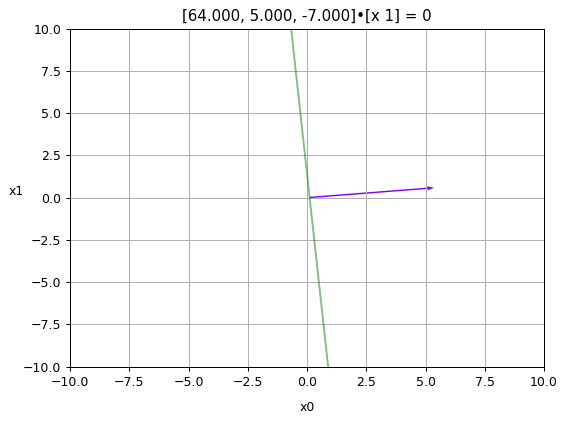

In [ ]:
fig = plt.figure(dpi=90)
orthogonal = gth.orthogonal_hyp()
inter = Hyperplane2D.intersection(gth, orthogonal)
samples = gth.make_line_sample_with_len(xstart=-0.7,line_len=21)
norm_vec = inter + gth.unit_norm_vec*2
plt.grid(True)
plt.title(f"{gth}")
plt.xlabel("x0", labelpad=10)
plt.ylabel("x1", rotation=0, labelpad=5)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.plot(samples[0], samples[1], color=(0, 0.5, 0, 0.5))
plt.quiver(*inter, *norm_vec, scale=8, color=(0.5, 0, 1), width=0.003)
plt.tight_layout()
plt.show()

## Genrate fake dataset and visualization

#### generate tools

In [ ]:
def generate_linear_separable_dataset(gth, N, seed = 1024) -> tuple[np.ndarray, np.ndarray]:
    total_N = int(N*1.5)
    data = gth.make_line_sample_with_len(gth.get_x0(8.5), line_len=16, n_point=total_N)
    np.random.seed(seed)
    selection_pos = np.random.permutation(np.arange(total_N))[:N]
    r_pos = np.random.uniform(low=0.3, high = 9 - data[0].max(), size=N)
    x_pos = data[0][selection_pos] + r_pos
    y_pos = data[1][selection_pos]
    pos_data = np.vstack([x_pos, y_pos]).T

    selection_neg = np.random.permutation(np.arange(total_N))[:N]
    r_neg = np.random.uniform(low=0.1, high = 9 - abs(data[0].min()), size=N)
    x_neg = data[0][selection_neg] - r_neg
    y_neg = data[1][selection_neg]
    neg_data = np.vstack([x_neg, y_neg]).T

    data_with_label = np.vstack(
    [
        np.hstack([pos_data, np.ones((pos_data.shape[0], 1))]),
        np.hstack([neg_data, -np.ones((neg_data.shape[0], 1))])
    ]
    )
    shuffle = np.random.permutation(data_with_label.shape[0])
    data_with_label = data_with_label[shuffle]
    return data_with_label[:, :2], data_with_label[:, -1]

def vis_linear_separable_data(x:np.ndarray, y:np.ndarray, gth:Hyperplane2D):

    fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=1000)
    orthogonal = gth.orthogonal_hyp()
    inter = Hyperplane2D.intersection(gth, orthogonal)
    samples = gth.make_line_sample_with_len(xstart=-0.7,line_len=21)
    norm_vec = inter + gth.unit_norm_vec*1
    print(gth)

    # First subplot
    axs[0].grid(True)
    axs[0].set_title("Linear Separable Dataset")
    axs[0].set_xlabel("x0", labelpad=10)
    axs[0].set_ylabel("x1", rotation=0, labelpad=5)
    axs[0].set_xlim(-10, 10)
    axs[0].set_ylim(-10, 10)
    axs[0].scatter(x=x[:, 0], y=x[:, 1], color=(0, 0, 0, 0.5), s=5)

    # Second subplot
    y_ = y.astype(np.int32)
    x_pos = x[y_ == 1]
    x_neg = x[y_ == -1]
    axs[1].grid(True)
    axs[1].set_title("Linear Separable Dataset with Hyperplane")
    axs[1].set_xlabel("x0", labelpad=10)
    axs[1].set_ylabel("x1", rotation=0, labelpad=5)
    axs[1].set_xlim(-10, 10)
    axs[1].set_ylim(-10, 10)
    axs[1].plot(samples[0], samples[1], color=(0, 0.5, 0, 0.5))
    axs[1].quiver(*norm_vec[:2], *norm_vec[2:], scale=8, color=(0.5, 0, 1), width=0.003)
    axs[1].scatter(x=x_pos[:, 0], y=x_pos[:, 1], color=(0, 0, 1, 0.5), s=5, label="+1")
    axs[1].scatter(x=x_neg[:, 0], y=x_neg[:, 1], color=(1, 0, 0, 0.5), s=5, label="-1")
    axs[1].legend()
    plt.tight_layout()
    plt.show()


### Make dataset

In [ ]:
N = 200
# 200, 500, 1000
gth = Hyperplane2D(norm_vector=np.array([64.0, 5.0, -7]))
x, y = generate_linear_separable_dataset(gth = gth, N=N)
print(x.shape, y.shape)

(400, 2) (400,)


In [ ]:
vis_linear_separable_data(x=x, y=y, gth=gth)

[64.000, 5.000, -7.000]•[x 1] = 0


## 2D Perceptron implementation

In [ ]:
class Perceptron2D(Hyperplane2D):

    def __init__(self, init_weights=None, x_pos=True) -> None:
        super().__init__(np.random.randn(3) if init_weights is None else init_weights, x_pos=x_pos)

    def __call__(self, x:np.ndarray, margin_form=False) -> np.ndarray:
        margin = super().__call__(x)
        return np.sign(margin).astype(np.int32) if not margin_form else margin

    def valid(self, x:np.ndarray, y:np.ndarray, return_idx:Literal["true", "false"]="false", need_margin:bool=False) -> Union[np.ndarray, tuple[np.ndarray, np.ndarray]]:
        M = None
        pred = self(x, margin_form=need_margin)

        if need_margin:
            M = pred.copy()
            pred = np.sign(pred).astype(np.int32)

        match return_idx:
            case "true":
                idx = np.where(pred == y)[0]
            case "false":
                idx = np.where(pred != y)[0]

        if need_margin:
            return idx, M[idx]
        else:
            return idx
    def train(self, x:np.ndarray, label:np.ndarray, method:Literal["pla","pokcet"]="pla", training_log:bool=False, max_iter:int=50) -> Union[tuple[dict[str, np.ndarray], float, int], tuple[float, int]]:
        """
        x: (N, 2)
        y: N
        """
        assert  method in ["pla", "pocket"]
        y = label.astype(np.int32) if label.dtype != np.int32 else label

        wrong = self.valid(x=x, y=y)
        t = 0
        log = []
        improve_points = []
        while wrong.shape[0]:

            if wrong.shape[0] == x.shape[0]:
                print("this line is actually a valid one, just reverse the representation of norm vector")
                self.norm_vector = self.norm_vector*(-1)
                break

            a_wrong = np.random.choice(wrong)
            provement = y[a_wrong]*np.append(x[a_wrong], 1)
            if training_log:
                log.append(Perceptron2D(init_weights=self.norm_vector.squeeze()))
                improve_points.append(a_wrong)
            self.norm_vector += provement
            t += 1
            wrong = self.valid(x=x, y=y)
            if t == max_iter:
                print(f"max iteration {max_iter} reached, remaining {wrong.shape[0]} errors")
                break


        acc = 1 - wrong.shape[0]/x.shape[0]
        print(f"finish, using {t} iterations, accuracy = {acc} over {x.shape[0]}")
        if training_log:
            log.append(Perceptron2D(init_weights=self.norm_vector.squeeze()))
            return {'perceptrons':log, 'update_points':improve_points}, acc, t
        return acc, t

    @staticmethod
    def vis_training_log(x:np.ndarray, y:np.ndarray, perceptron_logs:list["Perceptron2D"], improve_points:list[int], dpi=90, xrange=(-10, 10), gth:Hyperplane2D=None):

        fig, ax = plt.subplots(figsize=(8,5), dpi=dpi)

        pos_data = x[y>0]
        neg_data = x[y<0]


        line, = ax.plot([], [], color=(0,0,0), linewidth=1)
        if gth is not None:
            gth_samples = gth.make_line_sample(xrange=xrange)
            ax.plot(gth_samples[0, :], gth_samples[1, :], color=(0,0,0, 0.3), linewidth=1, label="gt")

        ax.scatter(x=pos_data[:, 0], y=pos_data[:, 1], color=(0, 0, 1, 0.3), s=3, label="+")
        ax.scatter(x=neg_data[:, 0], y=neg_data[:, 1], color=(1, 0, 0, 0.3), s=3, label="-")
        ax.set_xlim(xrange[0], xrange[1])
        ax.set_ylim(xrange[0], xrange[1])
        ax.set_xlabel('x0')
        ax.set_ylabel('x1')
        # ax.legend(loc='upper right',bbox_to_anchor=(1, 0.5), fontsize='small')
        ax.grid(True)

        target_scatter = []
        color_map = {1: (0, 0, 1), -1: (1, 0, 0)}

        ele_map = {
            'mistake':None,
            'error':None,
            'update':None,
            'next':None,
            'norm':None,
            'next_norm':None
        }
        inter = Hyperplane2D.intersection(perceptron_logs[0], perceptron_logs[0].orthogonal_hyp())
        hyp_map ={
            'next_l':perceptron_logs[0].make_line_sample(xrange=(-10, 10), corresponding_axis=0),
            'next_inter': inter,
            'next_norm_vec': inter + perceptron_logs[0].unit_norm_vec*1
        }
        first_frame = False

        def update(batch):

            epoch = batch//2

            l = hyp_map['next_l'].copy()
            inter = hyp_map['next_inter'].copy()
            norm_vec = hyp_map['next_norm_vec'].copy()


            if epoch < len(perceptron_logs)-1 and batch%2 == 0:
                hyp_map['next_l'] = perceptron_logs[epoch+1].make_line_sample(xrange=(-10, 10), corresponding_axis=0)
                hyp_map['next_inter'] = Hyperplane2D.intersection(perceptron_logs[epoch+1], perceptron_logs[epoch+1].orthogonal_hyp())
                hyp_map['next_norm_vec'] = hyp_map['next_inter'] + perceptron_logs[epoch+1].unit_norm_vec*1


            for key in ele_map:
                if ele_map[key] is not None:
                    ele_map[key].remove()
                    ele_map[key] = None

            if epoch < len(improve_points):
                p_idx = improve_points[epoch]
                target_scatter.clear()

                ele_map['mistake']=ax.scatter(
                    x[p_idx][0], x[p_idx][1],
                    color=color_map[int(y[p_idx])], s=20, marker="^"
                )
                if batch %2 == 0:
                    if batch > 0:
                        ele_map['update'] = ax.quiver(
                            *(norm_vec*2), *(y[p_idx]*x[p_idx]), angles='xy',
                            scale_units='xy', scale=1, color=(0, 0.6, 0), width=0.003, label="update"
                        )

                    ele_map['error'] = ax.quiver(
                        0, 0, *x[p_idx], angles='xy', scale_units='xy', scale=1,
                        color=(0.4, 0, 1, 0.6), width=0.003, label="error"
                    )
                    ele_map['next'] = (
                        ax.plot(
                            hyp_map['next_l'][0], hyp_map['next_l'][1], color=(0.396, 0.263, 0.129),
                            linewidth=1, label="next", linestyle="--"
                        )[0]
                    )

                elif batch%2 == 1:
                    line.set_xdata(hyp_map['next_l'][0])
                    line.set_ydata(hyp_map['next_l'][1])
                    line.set_label(f"{perceptron_logs[epoch+1]}")
                    ele_map['norm']= ax.quiver(
                        *hyp_map['next_inter'], *hyp_map['next_norm_vec'], angles='xy', scale_units='xy',
                        scale=0.5, color=(0, 0, 0), width=0.005, label="norm"
                    )

            if batch%2 == 0:
                if batch > 0:
                    ele_map['norm'] = ax.quiver(
                        *inter, *norm_vec, angles='xy', scale_units='xy',
                        scale=0.5, color=(0, 0, 0), width=0.005, label="norm"
                    )

                    line.set_xdata(l[0])
                    line.set_ydata(l[1])
                    line.set_label(f"{perceptron_logs[epoch]}")
                else:
                    #since first frame always get some bypass issue, using stupid way to solve
                    l = perceptron_logs[0].make_line_sample(xrange=(-10, 10), corresponding_axis=0)
                    inter = Hyperplane2D.intersection(perceptron_logs[0], perceptron_logs[0].orthogonal_hyp())
                    norm_vec = inter + perceptron_logs[0].unit_norm_vec*1
                    ele_map['norm'] = ax.quiver(
                        *inter, *norm_vec, angles='xy', scale_units='xy',
                        scale=0.5, color=(0, 0, 0), width=0.005, label="norm"
                    )
                    ele_map['update'] = ax.quiver(
                        *(norm_vec*2), *(y[p_idx]*x[p_idx]), angles='xy',
                        scale_units='xy', scale=1, color=(0, 0.6, 0), width=0.003, label="update"
                    )

                    line.set_xdata(l[0])
                    line.set_ydata(l[1])
                    line.set_label(f"{perceptron_logs[epoch]}")

            title_string = ""
            if epoch < len(perceptron_logs)-1:
                title_string = f"Training iteration {epoch}"
            else:
                title_string = f"Finish"

            ax.set_title(title_string)
            ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize='small')

            return line,

        step = [i for i in range(len(perceptron_logs)*2)][:-1]
        ani = FuncAnimation(fig, update, frames=step, blit=True, repeat=False)
        fig.tight_layout(pad = 1.0)
        plt.close()
        return HTML(ani.to_jshtml())



## PLA

In [ ]:
experiments = {
    'initial': [],
    'N':[],
    'iterations':[],
    "max_iterations":[],
    'accuracy':[],
    "cosine_similarity":[]
}

In [ ]:
max_iterations = np.inf
# 5, 10, 15, np.inf
init_weights = np.random.randn(3)
print(f"initial {Hyperplane2D(norm_vector=init_weights)}")
perceptron = Perceptron2D(init_weights=init_weights)
logs, acc, t = perceptron.train(x=x, label=y, method="pla", training_log=True, max_iter=max_iterations)
cos = gth.cosine_simi(logs['perceptrons'][-1])
print(f"similarity : {cos}")

experiments['initial'].append(Hyperplane2D(norm_vector=init_weights))
experiments['N'].append(x.shape[0])
experiments['iterations'].append(t)
experiments['max_iterations'].append(max_iterations)
experiments['accuracy'].append(acc)
experiments['cosine_similarity'].append(cos)


initial [0.366, -0.235, -2.432]•[x 1] = 0
finish, using 23 iterations, accuracy = 1.0 over 400
similarity : 0.9999837875366211


In [ ]:
Perceptron2D.vis_training_log(
    x=x, y=y,
    perceptron_logs = logs["perceptrons"],
    improve_points = logs["update_points"],
    xrange=(-10, 10), gth=gth
)

In [ ]:
df = pd.DataFrame(experiments)
df

initial    N  iterations  max_iterations  \
0  [0.366, -0.235, -2.432]•[x 1] = 0  400          23             inf   

   accuracy  cosine_similarity  
0       1.0           0.999984